## Geospatial Data Sciecne Workshop
### Professor Song Gao, Department of Geography @UW-Madison
### Faculty Affiliate of Data Science Institute @UW-Madison
### Email: song.gao@wisc.edu

## (1) Vector Data Processing

In [ ]:
import pandas as pd
import geopandas as gpd
import json

# Load geojson or shapefile of COVID-19 data at the census tract level
# https://data.dhsgis.wi.gov/datasets/wi-dhs::covid-19-data-by-census-tract-v2/about

with open('./data/COVID-19_Data_by_Census_Tract_V2/COVID-19_Data_by_Census_Tract_V2.geojson', 'r') as covid_file:
    covid_geojson = json.load(covid_file)
    
# Extract positive information of each census tract
covid_data = []
for feature in covid_geojson["features"]:
    geoid = feature["properties"]["GEOID"]
    date = feature["properties"]["Date"]
    positive = feature["properties"]["POS_CUM_CP"]
    covid_data.append([geoid, date, positive])
print(covid_data[0])

In [ ]:
# Construct the DataFrame of COVID-19 data
covid_data = pd.DataFrame(covid_data, columns=["ct", "date", "positive"])
covid_data.head()

In [ ]:
# Assign GEOID at multiple levels
covid_data["county"] = covid_data["ct"].apply(lambda x: str(x)[0:5])
covid_data

In [ ]:
## Read a GeoJSON File into a GeoPandas DataFrame
import geopandas as gpd
gdf = gpd.read_file('./data/COVID-19_Data_by_Census_Tract_V2/COVID-19_Data_by_Census_Tract_V2.geojson')
gdf.plot()
gdf

In [ ]:
## Create a choropleth map using the cumulative positive cases or another target variable
# https://geopandas.org/en/stable/docs/user_guide/mapping.html

import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

map = gdf.plot(column='POS_CUM_CP', ax=ax, legend=True)
map.set_axis_off()


In [ ]:
## Spatially zoom into the Dane County
# Assign GEOID at multiple levels
gdf["county"] = gdf["GEOID"].apply(lambda x: str(x)[0:5])
dane=gdf[gdf["county"]=='55025']
dane.plot()
dane

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

dane.plot(column='POS_CUM_CP', ax=ax, cmap='OrRd', legend=True)


### Multiscale Dynamic Human Mobility Flow Dataset in the U.S. during the COVID-19 Pandemic

Monitoring dynamic human mobility changes and travel flow patterns at different geographic scales is crucial for understanding human behavior changes during the COVID-19 pandemic. The open data created by the GeoDS Lab at UW-Madison are available at the census tract, county, and state levels. Please download one week of "weekly flow data" at the census tract level for Dane County, WI and convert them to ZCTA-to-ZCTA flow data matrix. 
## https://github.com/GeoDS/COVID19USFlows

In [ ]:
# %pip install wget ## a package to source data from websites

In [ ]:
## Download Data Files and store into a folder "mobilityflows"
# import wget
# data_folder="./mobilityflows"
# for i in range(20):
#     url = "https://raw.githubusercontent.com/GeoDS/COVID19USFlows-WeeklyFlows-Ct2021/master/weekly_flows/ct2ct/2021_01_04/weekly_ct2ct_2021_01_04_"+str(i)+".csv"
#     wget.download(url, out='./mobilityflows')


In [ ]:
# Merge all files
# import os
# import pandas as pd
# data_folder="./mobilityflows"
# flow_all = []
# for file in os.listdir(data_folder):
#     if file[-3:] == "csv" and 'weekly_ct2ct' in file:
#         print(data_folder+"/"+file)
#         flow_df = pd.read_csv(data_folder+"/"+file)
#         flow_all.append(flow_df)
# result = pd.concat([x for x in flow_all])
# result.to_csv("weekly_ct2ct_2021_01_04.csv", index=False)
# print(result.shape)
# result.head()

In [ ]:
print(result.shape)
print(result.dtypes)

In [ ]:
## filter out the data in Dane County (or another county) starting with GeoID 55025
result[[ 'geoid_o', 'geoid_d']] = result[['geoid_o','geoid_d']].astype(str) # Multiple columns string conversion
print(result.dtypes)
dane_county_flows_ct = result[result['geoid_o'].str.startswith('55025') & result['geoid_d'].str.startswith('55025')]
dane_county_flows_ct

## (2) Raster Data Analysis and Google Earth Engine

In [ ]:
# !pip install geemap

In [ ]:
# %pip install -U google-api-python-client==1.12.8
## https://github.com/giswqs/geemap/discussions/243!

###  Create your own personal Google Earth Engigne Account (free for academic and research use.)
https://code.earthengine.google.com/register

### Add the Dynymic World 10m near-real-time (NRT) Land Use/Land Cover (LULC) dataset that includes class label information for nine LULC classes: Water, Trees, Grass, Flooded vegetation, Crops, Shrub and Scrub, Built-up, Bare, Snow and ice from yr 2015-Present:

https://www.nature.com/articles/s41597-022-01307-4

In [23]:
import ee
import geemap

ee.Authenticate()

Map = geemap.Map()
Map.add_basemap('HYBRID')
Map


Successfully saved authorization token.


Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children=(Togg…

In [24]:
# Set the region of interest by simply drawing a polygon on the map
region = Map.user_roi
if region is None:
    region = ee.Geometry.BBox(-89.7088, 42.9006, -89.0647, 43.2167) ## You can also set a Polygon: ee.Geometry.Polygon()
Map.centerObject(region)

In [25]:
# Set the date range to query the data
start_date = '2016-01-01'
end_date = '2016-12-31'

In [26]:
# Create Dynamic World land cover composite
# The "return_type" can be hillshade, visualize, class, or probability. 
# If you want to use the resulting images for further analysis, you should use class.

landcover = geemap.dynamic_world(region, start_date, end_date, return_type='hillshade')
Map.addLayer(landcover, {}, 'Land Cover')
# Add legend to the map
Map.add_legend(title="Dynamic World Land Cover", builtin_legend='Dynamic_World')
Map.centerObject(region)
Map

Map(bottom=96572.0, center=[43.052833917627936, -89.39575195312501], controls=(WidgetControl(options=['positio…

In [27]:
## Return "class" images for further zonal summary analysis 
classes = geemap.dynamic_world(region, start_date, end_date, return_type='class')
df = geemap.image_area_by_group(classes, region=region, scale=10, denominator=1e6)
df

Calculating area for group 0 ...
Calculating area for group 1 ...
Calculating area for group 2 ...
Calculating area for group 3 ...
Calculating area for group 4 ...
Calculating area for group 5 ...
Calculating area for group 6 ...
Calculating area for group 7 ...
Calculating area for group 8 ...


,area,percentage
group,,
0,90.1620,0.0503
1,356.2181,0.1986
2,98.4425,0.0549
3,3.2941,0.0018
4,661.7954,0.3689
5,3.1045,0.0017
6,283.1382,0.1578
7,6.5681,0.0037
8,291.3155,0.1624


## Create Landsat satellite image timeseries
https://geemap.org/geemap/#geemap.geemap.Map.add_landsat_ts_gif


In [ ]:
# %pip install ffmpeg-python

In [28]:
import os
out_dir = os.path.join(os.path.expanduser("~"), 'Downloads')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

Map = geemap.Map()
label = 'Land Cover/Use Changes in Doha, Qatar'

# Set the region of interest by simply drawing a polygon on the map
region = Map.user_roi
if region is None:
    region = ee.Geometry.BBox(51.23621, 25.24974, 51.71862, 25.48035) # set your own region bounding box
# ee.Geometry.BBox(-89.7088, 42.9006, -89.0647, 43.2167) # Madison bounding box

Map.centerObject(region)

Map.add_landsat_ts_gif(
    label=label,
    roi=region,
    start_year=1985,
    bands=['Red', 'Green', 'Blue'],
    font_color='white',
    frames_per_second=5,
    progress_bar_color='blue',
    out_gif=out_dir+'/landsat_ts.gif',
)

Generating URL...
Please wait ...
The GIF image has been saved to: C:\Users\willi\Downloads\landsat_ts.gif
Adding GIF to the map ...
The timelapse has been added to the map.


## (3) Street Network Analysis Using OSMnx
- [GitHub repo](https://github.com/gboeing/osmnx)

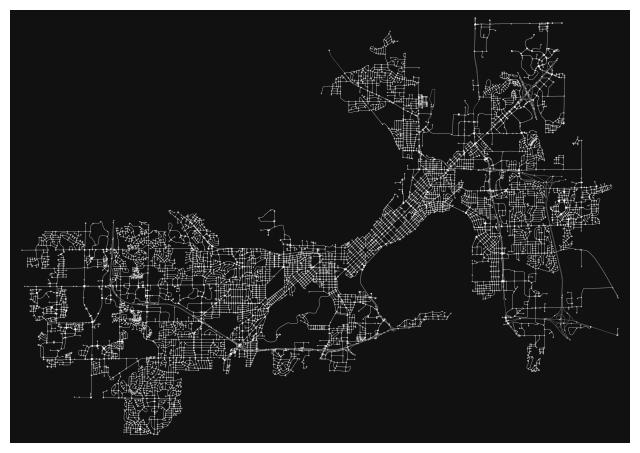

In [29]:
import matplotlib.cm as cm
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
%matplotlib inline

# get the network for downloading
G = ox.graph_from_place('Madison, WI, USA', network_type='drive', simplify=True)
fig, ax = ox.plot_graph(G, figsize=(8,8), node_size=1, node_alpha=0.5,
                        edge_linewidth=0.2, save=True, dpi=200,filepath='./madison.jpg')

In [30]:
## Compute network stats
G = nx.MultiDiGraph(G) # convert a MultiGraph to simple Graph
print(G)
betweennessCentrality = nx.edge_betweenness_centrality(G, normalized=True) # (start_node, end_node) : betw_value
print(nx.number_of_nodes(G))
print(nx.number_of_edges(G))
print(len(betweennessCentrality))

MultiDiGraph with 8644 nodes and 21514 edges
8644
21514
21514


len(Betweenness) 21514
0.0 0.19841585014593704
len(Betweenness_list) 21514
1.33850725280863e-08 1
len(color_scale) 21514


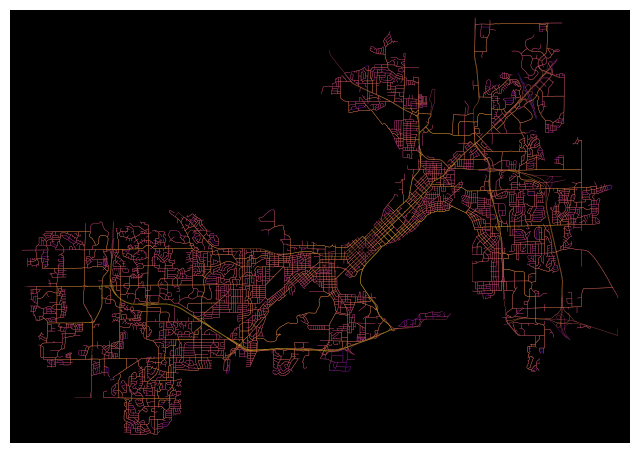

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [39]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# print(G.edges())

# fixed dictionary!!!!! need to add 0 as third value
try:
    Betweenness = [betweennessCentrality[edge[0], edge[1], 0] for edge in G.edges()]
except KeyError:
    print('no good')

print('len(Betweenness)', len(Betweenness))
print(min(Betweenness), max(Betweenness))

#nx.set_edge_attributes(G, betweennessCentrality, "edge_bc")

Betweenness_list = [i if i != 0 else 1 for i in Betweenness] # for visualization use only (0,1)
print('len(Betweenness_list)',len(Betweenness_list))
print(min(Betweenness_list), max(Betweenness_list))

#color scale converted to list of colors for graph edges
#norm = colors.Normalize(vmin=min(Betweenness), vmax=max(Betweenness))
#norm = colors.PowerNorm(gamma=2,vmin=min(Betweenness), vmax=max(Betweenness))
norm = colors.LogNorm(vmin=min(Betweenness_list), vmax=max(Betweenness_list))
cmap = cm.ScalarMappable(norm=norm, cmap=cm.plasma)
color_scale = [cmap.to_rgba(cl) for cl in Betweenness]
print('len(color_scale)',len(color_scale))
## osmnx ploting requires the MultiGraph type
ox.plot_graph(G, bgcolor='k',node_size=0, edge_linewidth=0.2, edge_color=color_scale,edge_alpha=1)